In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
import tensorflow as tf
import IPython.display as ipd
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, MaxPool2D
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib
import math
import os
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import IPython.display as ipd
import librosa
import librosa.display
print('finished importing')

my_dir = '/content/drive/My Drive/'
os.chdir(my_dir)

channels = 1
classes = 4
mfccs = np.load('mfccs_without_0_preprocessed_v6.npy').tolist()
mfccs = np.asarray(mfccs)
labels = np.load('labels_without_0_preprocessed_v6.npy')

dim_1 = mfccs.shape[1]
dim_2 = mfccs.shape[2]

X = mfccs
print(X.shape)
X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
print(X.shape)
y = labels
input_shape = (dim_1, dim_2, channels)

finished importing
(2591, 60, 60)
(2591, 60, 60, 1)


In [97]:
def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

def ToneNet(input_shape, num_classes, activation):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(3, 3), strides=(3, 3), padding='same'))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # print(model.summary())
    sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

# Training and Testing
*Note: Results shown are from training/testing only male data, but code also works for the complete dataset*

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# model = get_cnn_model(input_shape, classes)
model = ToneNet(input_shape, classes, 'relu')

from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_train]

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_ints), y=y_ints)

train_class_weights = dict(enumerate(class_weights))

checkpointer = ModelCheckpoint(filepath="Model/model.hdf5", verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=15)
history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2, callbacks=[checkpointer, earlystopping], class_weight=train_class_weights)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.5261 - accuracy: 0.2903
Epoch 1: val_loss improved from inf to 1.51723, saving model to Model/model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 25s 914ms/step - loss: 1.5261 - accuracy: 0.2903 - val_loss: 1.5172 - val_accuracy: 0.1295
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.2916 - accuracy: 0.4062
Epoch 2: val_loss improved from 1.51723 to 1.43244, saving model to Model/model.hdf5
23/23 [==============================] - 20s 877ms/step - loss: 1.2916 - accuracy: 0.4062 - val_loss: 1.4324 - val_accuracy: 0.3581
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.1454 - accuracy: 0.4717
Epoch 3: val_loss improved from 1.43244 to 1.35324, saving model to Model/model.hdf5
23/23 [==============================] - 20s 883ms/step - loss: 1.1454 - accuracy: 0.4717 - val_loss: 1.3532 - val_accuracy: 0.3333
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.5545
Epoch 4: val_loss improved from 1.35324 to 1.27465, saving model to Model/model.hdf5
23/23 [==============================] - 19s 852ms/step - loss: 

In [103]:
model_saved = load_model("Model/model.hdf5")
model_saved.evaluate(X_test, y_test, batch_size = 3, verbose = 1)

260/260 [==============================] - 3s 11ms/step - loss: 1.2265 - accuracy: 0.5077


[1.2265082597732544, 0.5077120661735535]

# Evaluation of Model Performance

In [104]:
# evaluate model
model.evaluate(X_test, y_test, batch_size = 3, verbose = 1)

260/260 [==============================] - 3s 12ms/step - loss: 1.7247 - accuracy: 0.4974


[1.7246514558792114, 0.4974293112754822]

In [105]:
# evaluate model on training
model.evaluate(X_train, y_train, batch_size = 3, verbose = 1)


605/605 [==============================] - 9s 14ms/step - loss: 0.5769 - accuracy: 0.8158


[0.5768924355506897, 0.8157749772071838]

In [106]:
# Evaluation metrics from scikit learn

import sklearn.metrics as metrics

y_pred = model.predict(X_test).ravel()
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

y_true_labels = np.argmax(y_test, axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)


25/25 [==============================] - 1s 31ms/step
[[161  14  48  38]
 [ 68  73  45  31]
 [ 28  12  63  33]
 [ 34   1  39  90]]


25/25 [==============================] - 1s 27ms/step
Confusion matrix, without normalization
[[161  14  48  38]
 [ 68  73  45  31]
 [ 28  12  63  33]
 [ 34   1  39  90]]


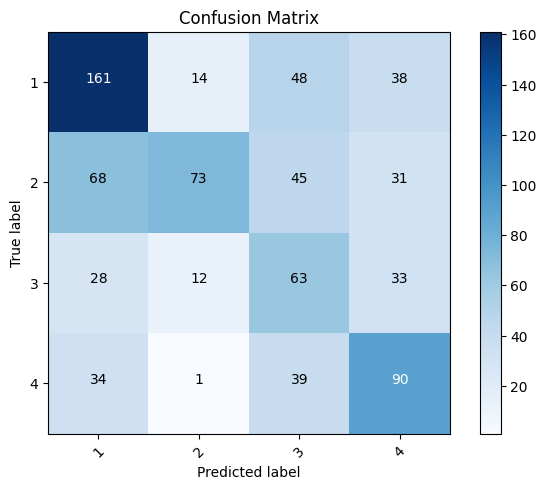

In [107]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_test).ravel()

y_true_labels = np.argmax(y_test, axis=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true_labels, y_pred_labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[1, 2, 3, 4],
                      title='Confusion Matrix')

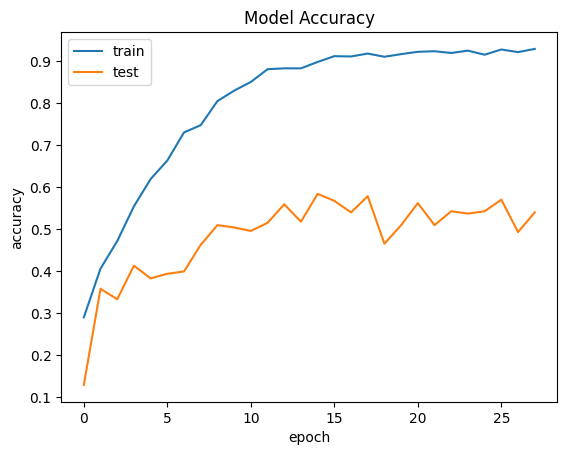

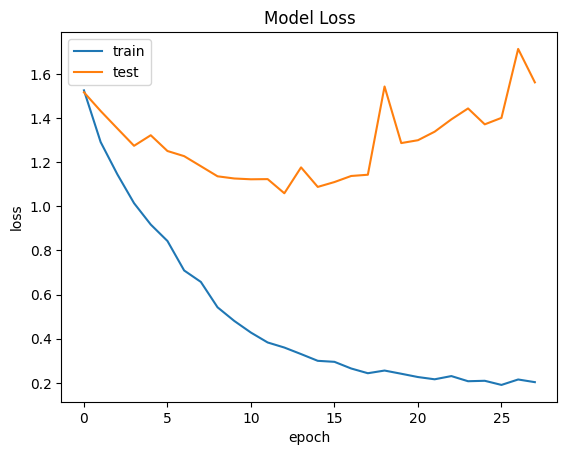

In [108]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()